# Beyond the Efficient Market Dogma: An Empirical Examination of Market Inefficiencies

## Author: Shreyash Naresh Maheshwari

#### Abstract

The Efficient Market Hypothesis (EMH) has long been a cornerstone in financial theory, asserting that markets instantly incorporate all available information, rendering it impossible to consistently outperform the market. However, a growing body of evidence challenges this dogma, suggesting the presence of persistent market inefficiencies. This study aims to empirically investigate and analyse these alleged inefficiencies, questioning the traditional EMH paradigm and seeking a deeper understanding of factors contributing to market anomalies. 

Additionally, the research explores alternative hypotheses such as the Fractal Market Hypothesis and Novelty-Narrative Hypothesis, aiming to assess their validity in explaining observed deviations from market efficiency. By doing so, the study seeks to shed light on the potential for investors to exploit these inefficiencies for improved financial decision-making and performance.


In [1]:
#%% Import Required Packages
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from arch.unitroot import VarianceRatio
from statsmodels.sandbox.stats.runs import runstest_1samp 
from hurst import compute_Hc
from scipy.stats import pearsonr
from scipy.stats import skewtest, kurtosistest

In [2]:
#%% Set Start and End Dates
tz = pytz.timezone("Asia/Calcutta")
start = tz.localize(datetime.datetime(2014,1,1))
end = tz.localize(datetime.datetime(2024,1,1))

In [3]:
#%% List of NIFTY50 Stocks and Index

tickers = ['ADANIPORTS', 'ADANIENT', 'APOLLOHOSP', 'AXISBANK', 'ASIANPAINT', 'BAJAJFINSV', 
'BAJAJ-AUTO', 'BAJFINANCE', 'BRITANNIA', 'BHARTIARTL', 'BPCL', 'CIPLA', 'COALINDIA', 
'DRREDDY', 'DIVISLAB', 'EICHERMOT', 'GRASIM', 'HINDALCO', 'HDFCBANK', 'HDFCLIFE', 
'HCLTECH', 'HINDUNILVR', 'HEROMOTOCO', 'ICICIBANK', 'ITC', 'INFY', 'INDUSINDBK', 
'JSWSTEEL', 'KOTAKBANK', 'LT', 'LTIM', 'M&M', 'MARUTI', 'NESTLEIND', 'ONGC', 
'NTPC', 'POWERGRID', 'RELIANCE', 'SBIN', 'SBILIFE', 'SUNPHARMA', 'TATASTEEL', 
'TATACONSUM', 'TATAMOTORS', 'TCS', 'TECHM', 'TITAN', 'UPL', 'ULTRACEMCO', 'WIPRO']

index_name = '^NSEI'

In [4]:
#%% Download historical data from Yahoo Finance

# NIFTY50 Daily Closing Price
NIFTY50_OHLC = yf.download(index_name, start=start, end=end, progress=False) #Extract the Closing Price
NIFTY50_Values = NIFTY50_OHLC['Close']
NIFTY50_Values.rename("NIFTY50", inplace = True)

# NIFTY50 Minimum Change Price
NIFTY_min_move = pd.Series(np.zeros(NIFTY50_OHLC.shape[0]))
NIFTY_min_move.iloc[0] = NIFTY50_OHLC.iloc[0,3]

for i in range(NIFTY50_OHLC.shape[0] - 1):
    if NIFTY50_OHLC.iloc[i+1, 2] <= NIFTY50_OHLC.iloc[i, 3] and NIFTY50_OHLC.iloc[i+1, 1] >= NIFTY50_OHLC.iloc[i, 3]:
        NIFTY_min_move.iloc[i+1] = NIFTY50_OHLC.iloc[i, 3]
    elif NIFTY50_OHLC.iloc[i+1, 1] < NIFTY50_OHLC.iloc[i, 3]:
        NIFTY_min_move.iloc[i+1] = NIFTY50_OHLC.iloc[i+1, 1]
    elif NIFTY50_OHLC.iloc[i+1, 2] > NIFTY50_OHLC.iloc[i, 3]:
        NIFTY_min_move.iloc[i+1] = NIFTY50_OHLC.iloc[i+1, 2]
    else:
        None
    
NIFTY_min_move.index = NIFTY50_OHLC.index #Reset the datetime index

# NIFTY50 Constituents Daily Closing Price
stock_prices = pd.DataFrame()
min_move_prices = pd.DataFrame()
Symbols = tickers

#Iterate over each Symbol
for i in Symbols:
    df = yf.download(i+'.NS',start=start, end=end, progress=False)
    df.index = df.index.tz_localize(None) #Removing timezone information from DatetimeIndex  
    stock_prices = pd.concat([stock_prices, df['Close']], axis = 1)
    
    stock_min_move = pd.Series(np.zeros(df.shape[0]))
    stock_min_move.iloc[0] = df.iloc[0,3]
    
    for i in range(df.shape[0]-1):
        if df.iloc[i+1, 2] <= df.iloc[i, 3] and df.iloc[i+1, 1] >= df.iloc[i, 3]:
            stock_min_move.iloc[i+1] = df.iloc[i, 3]
        elif df.iloc[i+1, 1] < df.iloc[i, 3]:
            stock_min_move.iloc[i+1] = df.iloc[i+1, 1]
        elif df.iloc[i+1, 2] > df.iloc[i, 3]:
            stock_min_move.iloc[i+1] = df.iloc[i+1, 2]
        else:
            None
    
    stock_min_move.index = df.index
    
    min_move_prices = pd.concat([min_move_prices, stock_min_move], axis = 1)
            
            
#Rename the columns as per stock names
stock_prices.columns = Symbols 
min_move_prices.columns = Symbols

Text(0, 0.5, 'Closing Price')

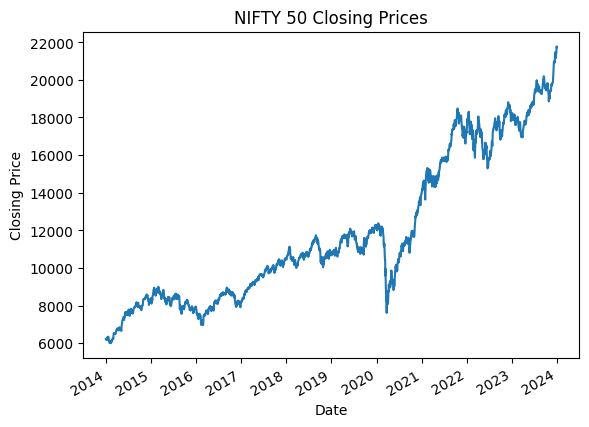

In [5]:
#%% Exploratory Data Analysis

# NIFTY 50 Time Series Plot
NIFTY50_Values.plot(title='NIFTY 50 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

In [6]:
# Descriptive Statistics of NIFTY 50 Log Returns
print("\nSummary Statistics for NIFTY 50 Log Returns:")
print(pd.Series(np.diff(np.log(NIFTY50_Values))).describe())


Summary Statistics for NIFTY 50 Log Returns:
count    2452.000000
mean        0.000510
std         0.010484
min        -0.139038
25%        -0.004331
50%         0.000779
75%         0.006120
max         0.084003
dtype: float64


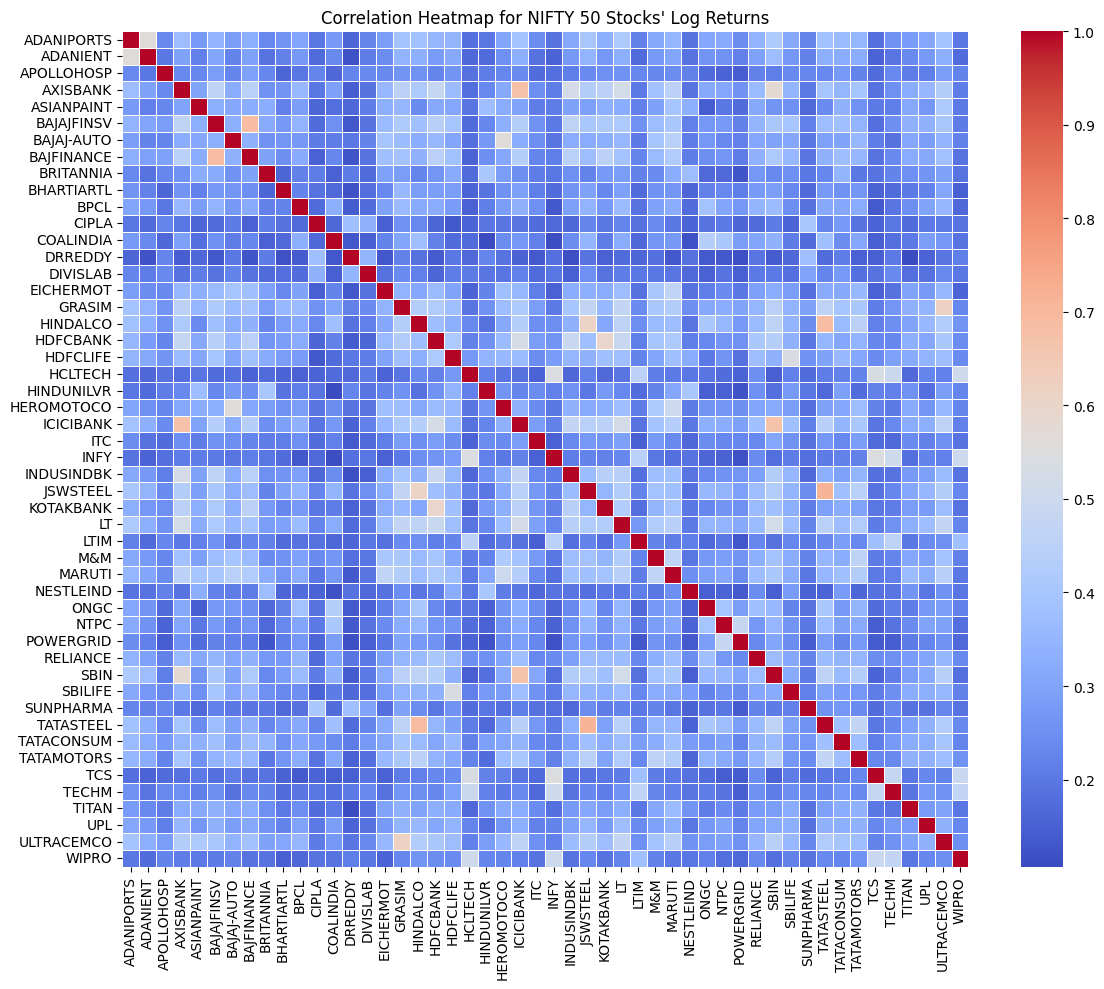

In [7]:
# Correlation Heatmap of NIFTY 50 Stocks' Returns
plt.figure(figsize=(12, 10))
sns.heatmap(np.log1p(stock_prices.pct_change()).iloc[1:,].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for NIFTY 50 Stocks' Log Returns")
plt.tight_layout()
plt.show()

In [8]:
# Descriptive Statistics of NIFTY 50 Stocks' Log Returns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
print("\nSummary Statistics for NIFTY 50 Stocks' Log Returns:")
print(np.log1p(stock_prices.pct_change()).iloc[1:,].describe().T)


Summary Statistics for NIFTY 50 Stocks' Log Returns:
             count      mean       std       min       25%       50%  \
ADANIPORTS  2464.0  0.000763  0.024272 -0.212933 -0.010843  0.000286   
ADANIENT    2464.0  0.001719  0.034757 -0.490194 -0.012182  0.001675   
APOLLOHOSP  2464.0  0.000719  0.020624 -0.162396 -0.010314 -0.000040   
AXISBANK    2464.0  0.000589  0.021569 -0.327266 -0.009731  0.000534   
ASIANPAINT  2464.0  0.000778  0.016154 -0.151148 -0.007779  0.000531   
BAJAJFINSV  2464.0  0.001258  0.021435 -0.299244 -0.009401  0.000522   
BAJAJ-AUTO  2464.0  0.000514  0.015812 -0.147111 -0.007408  0.000148   
BAJFINANCE  2464.0  0.001560  0.023312 -0.264367 -0.009188  0.000900   
BRITANNIA   2464.0  0.000996  0.015997 -0.143526 -0.007028  0.000310   
BHARTIARTL  2464.0  0.000496  0.018966 -0.127298 -0.009884 -0.000061   
BPCL        2464.0  0.000549  0.021841 -0.221710 -0.010672  0.000240   
CIPLA       2464.0  0.000459  0.016705 -0.092397 -0.008376 -0.000375   
COALINDIA 

In [9]:
#%% Create DataFrame of RESULTS1, RESULTS2 & set the Row names

RESULTS1 = pd.DataFrame(np.zeros([51, 11]))
RESULTS1.iloc[0,0] = 'NIFTY50'
RESULTS1.iloc[1:,0] = tickers

RESULTS2 = pd.DataFrame(np.zeros([51, 11]))
RESULTS2.iloc[0,0] = 'NIFTY50'
RESULTS2.iloc[1:,0] = tickers

In [10]:
#%% ADF Test p values for stock prices

RESULTS1.iloc[0, 1] = adfuller(NIFTY50_Values)[1]
for i in range(len(tickers)):
    RESULTS1.iloc[i+1, 1] = adfuller(stock_prices.iloc[:, i].dropna())[1]

RESULTS2.iloc[0, 1] = adfuller(NIFTY_min_move)[1]
for i in range(len(tickers)):
    RESULTS2.iloc[i+1, 1] = adfuller(min_move_prices.iloc[:, i].dropna())[1]

#%% Serial Correlation Test (Ljung-Box test) for log returns at 10 lags
# Combined p value obtained as Equal Weighted Harmonic Mean

p_values = acorr_ljungbox(np.diff(np.log(NIFTY50_Values)), return_df=False)[1]
RESULTS1.iloc[0, 2] = len(p_values) / np.sum(1 / p_values)
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    p_values = acorr_ljungbox(log_returns, return_df=False)[1]
    RESULTS1.iloc[i+1, 2] = len(p_values) / np.sum(1 / p_values)

p_values = acorr_ljungbox(np.diff(np.log(NIFTY_min_move)), return_df=False)[1]
RESULTS2.iloc[0, 2] = len(p_values) / np.sum(1 / p_values)
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    p_values = acorr_ljungbox(log_returns, return_df=False)[1]
    RESULTS2.iloc[i+1, 2] = len(p_values) / np.sum(1 / p_values)

#%% Normality Test p values for log returns

RESULTS1.iloc[0, 3] = shapiro(np.diff(np.log(NIFTY50_Values)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    RESULTS1.iloc[i+1, 3] = shapiro(log_returns)[1]

RESULTS2.iloc[0, 3] = shapiro(np.diff(np.log(NIFTY_min_move)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    RESULTS2.iloc[i+1, 3] = shapiro(log_returns)[1]

#%% Variance Ratio Test p values for log returns ; check change in variance over 1 month / 20 trading days

RESULTS1.iloc[0, 4] = VarianceRatio(np.diff(np.log(NIFTY50_Values)), lags = 20).pvalue
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    RESULTS1.iloc[i+1, 4] = VarianceRatio(log_returns, lags = 20).pvalue

RESULTS2.iloc[0, 4] = VarianceRatio(np.diff(np.log(NIFTY_min_move)), lags = 20).pvalue
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    RESULTS2.iloc[i+1, 4] = VarianceRatio(log_returns, lags = 20).pvalue


#%% Runs Test (Wald-Wolfowitz) for log returns

NIFTY_BINARY_RETURNS = (np.diff(np.log(NIFTY50_Values)) > 0) * 1
RESULTS1.iloc[0, 5] = runstest_1samp(NIFTY_BINARY_RETURNS)[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    bin_returns = (log_returns > 0) * 1
    RESULTS1.iloc[i+1, 5] = runstest_1samp(bin_returns)[1]

NIFTY_BINARY_RETURNS = (np.diff(np.log(NIFTY_min_move)) > 0) * 1
RESULTS2.iloc[0, 5] = runstest_1samp(NIFTY_BINARY_RETURNS)[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    bin_returns = (log_returns > 0) * 1
    RESULTS2.iloc[i+1, 5] = runstest_1samp(bin_returns)[1]

#%% Hurst Exponent of Closing Prices

RESULTS1.iloc[0, 6] = compute_Hc(NIFTY50_Values, kind = 'price')[0]
for i in range(len(tickers)):
    RESULTS1.iloc[i+1, 6] = compute_Hc(stock_prices.iloc[:, i].dropna())[1]

RESULTS2.iloc[0, 6] = compute_Hc(NIFTY_min_move, kind = 'price')[0]
for i in range(len(tickers)):
    RESULTS2.iloc[i+1, 6] = compute_Hc(min_move_prices.iloc[:, i].dropna())[1]

#%% Pearson Correlation Test of log returns at 5 Day Lags

x = np.diff(np.log(NIFTY50_Values))[:-5]  # Current Log Returns
y = np.diff(np.log(NIFTY50_Values))[5:]   # 5 Day Lag Log Returns
RESULTS1.iloc[0, 7] = pearsonr(x, y)[1]
for i in range(len(tickers)):
    x = np.diff(np.log(stock_prices.iloc[:, i].dropna()))[:-5] # Current Log Returns
    y = np.diff(np.log(stock_prices.iloc[:, i].dropna()))[5:] # 5 Day Lag Log Returns
    RESULTS1.iloc[i+1, 7] = pearsonr(x, y)[1]

x = np.diff(np.log(NIFTY_min_move))[:-5]  # Current Log Returns
y = np.diff(np.log(NIFTY_min_move))[5:]   # 5 Day Lag Log Returns
RESULTS2.iloc[0, 7] = pearsonr(x, y)[1]
for i in range(len(tickers)):
    x = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))[:-5] # Current Log Returns
    y = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))[5:] # 5 Day Lag Log Returns
    RESULTS2.iloc[i+1, 7] = pearsonr(x, y)[1]

#%% Volatility Clustering Test p values
# Serial Correlation Test (Ljung-Box test) for squared log returns
# Combined p value obtained as Equal Weighted Harmonic Mean

p_values = acorr_ljungbox(np.diff(np.log(NIFTY50_Values))**2, return_df=False)[1]
RESULTS1.iloc[0, 8] = len(p_values) / np.sum(1 / p_values)
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    p_values = acorr_ljungbox(log_returns**2, return_df=False)[1]
    RESULTS1.iloc[i+1, 8] = len(p_values) / np.sum(1 / p_values)

p_values = acorr_ljungbox(np.diff(np.log(NIFTY_min_move))**2, return_df=False)[1]
RESULTS2.iloc[0, 8] = len(p_values) / np.sum(1 / p_values)
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    p_values = acorr_ljungbox(log_returns**2, return_df=False)[1]
    RESULTS2.iloc[i+1, 8] = len(p_values) / np.sum(1 / p_values)

#%% Skewness Test p values for log returns

RESULTS1.iloc[0, 9] = skewtest(np.diff(np.log(NIFTY50_Values)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    RESULTS1.iloc[i+1, 9] = skewtest(log_returns)[1]

RESULTS2.iloc[0, 9] = skewtest(np.diff(np.log(NIFTY_min_move)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    RESULTS2.iloc[i+1, 9] = skewtest(log_returns)[1]

#%% Kurtosis Test

RESULTS1.iloc[0, 10] = kurtosistest(np.diff(np.log(NIFTY50_Values)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(stock_prices.iloc[:, i].dropna()))
    RESULTS1.iloc[i+1, 10] = kurtosistest(log_returns)[1]

RESULTS2.iloc[0, 10] = kurtosistest(np.diff(np.log(NIFTY_min_move)))[1]
for i in range(len(tickers)):
    log_returns = np.diff(np.log(min_move_prices.iloc[:, i].dropna()))
    RESULTS2.iloc[i+1, 10] = kurtosistest(log_returns)[1]

C:\Users\Maheshwari\AppData\Local\Temp\ipykernel_12332\3882091229.py:102: RuntimeWarning: divide by zero encountered in divide
  RESULTS1.iloc[0, 8] = len(p_values) / np.sum(1 / p_values)
C:\Users\Maheshwari\AppData\Local\Temp\ipykernel_12332\3882091229.py:106: RuntimeWarning: divide by zero encountered in divide
  RESULTS1.iloc[i+1, 8] = len(p_values) / np.sum(1 / p_values)


In [11]:
#%% Formatting & Column Names

RESULTS1.columns = ['TICKER', 'ADF Test', 'Serial Correlation Test', 'Normality Test', 
                   'Variance Ratio Test', 'Runs Test', 'Hurst Exponent', 
                   'Correlation Test', 'Volatility Clustering Test', 'Skewness Test', 'Kurtosis Test']
                   
RESULTS2.columns = ['TICKER', 'ADF Test', 'Serial Correlation Test', 'Normality Test', 
                   'Variance Ratio Test', 'Runs Test', 'Hurst Exponent', 
                   'Correlation Test', 'Volatility Clustering Test', 'Skewness Test', 'Kurtosis Test']

## Results 1: Table of p-values for statistical tests on Closing Prices

In [12]:
RESULTS1.style.format({'ADF Test' : "{:.2%}", 'Serial Correlation Test' : "{:.2%}", 'Normality Test' : "{:.2%}", 
                      'Variance Ratio Test' : "{:.2%}", 'Runs Test' : "{:.2%}", 'Hurst Exponent' : "{:.4f}",
                      'Correlation Test' : "{:.2%}",  'Volatility Clustering Test' : "{:.2%}", 
                      'Skewness Test' : "{:.2%}", 'Kurtosis Test' : "{:.2%}" })

,TICKER,ADF Test,Serial Correlation Test,Normality Test,Variance Ratio Test,Runs Test,Hurst Exponent,Correlation Test,Volatility Clustering Test,Skewness Test,Kurtosis Test
0,NIFTY50,98.30%,0.00%,0.00%,0.12%,0.00%,0.7041,0.00%,0.00%,0.00%,0.00%
1,ADANIPORTS,91.42%,17.34%,0.00%,0.00%,91.87%,1.0988,72.57%,0.00%,0.00%,0.00%
2,ADANIENT,86.21%,0.24%,0.00%,0.00%,80.38%,0.9690,87.38%,0.00%,0.00%,0.00%
3,APOLLOHOSP,98.99%,0.36%,0.00%,0.00%,42.07%,1.0069,15.09%,0.00%,0.00%,0.00%
4,AXISBANK,70.16%,66.70%,0.00%,0.00%,55.38%,1.3255,42.02%,0.00%,0.00%,0.00%
5,ASIANPAINT,91.64%,32.42%,0.00%,0.00%,3.53%,0.9261,91.80%,0.00%,0.00%,0.00%
6,BAJAJFINSV,85.71%,1.22%,0.00%,0.00%,24.10%,1.0568,44.33%,0.00%,0.00%,0.00%
7,BAJAJ-AUTO,99.83%,76.51%,0.00%,0.00%,83.29%,1.1786,77.85%,0.00%,0.62%,0.00%
8,BAJFINANCE,85.88%,0.00%,0.00%,0.00%,46.76%,1.0339,3.25%,0.00%,0.00%,0.00%
9,BRITANNIA,90.84%,2.10%,0.00%,0.00%,40.61%,0.9706,82.17%,0.00%,0.02%,0.00%


## Results 2: Table of p-values for statistical tests on Minimum Change Prices

In [13]:
RESULTS2.style.format({'ADF Test' : "{:.2%}", 'Serial Correlation Test' : "{:.2%}", 'Normality Test' : "{:.2%}",
                      'Variance Ratio Test' : "{:.2%}", 'Runs Test' : "{:.2%}", 'Hurst Exponent' : "{:.4f}",
                      'Correlation Test' : "{:.2%}",  'Volatility Clustering Test' : "{:.2%}",  
                      'Skewness Test' : "{:.2%}", 'Kurtosis Test' : "{:.2%}" })

,TICKER,ADF Test,Serial Correlation Test,Normality Test,Variance Ratio Test,Runs Test,Hurst Exponent,Correlation Test,Volatility Clustering Test,Skewness Test,Kurtosis Test
0,NIFTY50,98.38%,0.00%,0.00%,0.00%,0.00%,0.7175,66.27%,0.00%,0.03%,0.00%
1,ADANIPORTS,91.79%,0.03%,0.00%,0.00%,2.75%,1.1235,73.49%,0.00%,0.00%,0.00%
2,ADANIENT,88.54%,0.00%,0.00%,0.00%,4.57%,1.0054,83.73%,0.00%,0.00%,0.00%
3,APOLLOHOSP,99.09%,0.04%,0.00%,0.00%,8.37%,1.0187,26.23%,0.00%,0.00%,0.00%
4,AXISBANK,67.79%,0.00%,0.00%,0.00%,1.84%,1.3795,27.69%,0.00%,0.00%,0.00%
5,ASIANPAINT,91.27%,4.00%,0.00%,0.00%,75.01%,0.9484,84.39%,0.00%,59.90%,0.00%
6,BAJAJFINSV,85.19%,0.00%,0.00%,0.00%,1.17%,1.0754,93.71%,0.00%,0.00%,0.00%
7,BAJAJ-AUTO,99.77%,8.20%,0.00%,0.00%,15.55%,1.2269,52.88%,0.00%,0.00%,0.00%
8,BAJFINANCE,85.10%,0.00%,0.00%,0.00%,1.59%,1.0592,99.01%,0.00%,8.21%,0.00%
9,BRITANNIA,90.57%,0.14%,0.00%,0.00%,5.16%,0.9951,69.81%,0.00%,0.00%,0.00%


## Events Impact Analysis

In [14]:
# Load the dataset
events_input = pd.read_csv("F:\\Events_Data_Input.csv", parse_dates=True)

# Change columns to date format
events_input.iloc[ :, 0] = pd.to_datetime(events_input.iloc[ :, 0], format = '%d-%m-%Y').dt.date
events_input.iloc[ :, 1] = pd.to_datetime(events_input.iloc[ :, 1], format = '%d-%m-%Y').dt.date
events_input.iloc[ :, 2] = pd.to_datetime(events_input.iloc[ :, 2], format = '%d-%m-%Y').dt.date
events_input.iloc[ :, 3] = pd.to_datetime(events_input.iloc[ :, 3], format = '%d-%m-%Y').dt.date

# Download Closing Prices
stock_list = ['HDFCBANK.NS', 'RELIANCE.NS', 'ICICIBANK.NS', 'AXISBANK.NS', 'ITC.NS', 'LT.NS', 'INFY.NS', 'TCS.NS']
stock_prices = yf.download(stock_list, '2014-01-01', '2024-01-01')['Close']
stock_prices.columns = ['HDFCBANK', 'RELIANCE', 'ICICIBANK', 'AXISBANK', 'ITC', 'LT', 'INFY', 'TCS']
stock_prices.index = stock_prices.index.date

[*********************100%%**********************]  8 of 8 completed


In [15]:
#%% Enter the Required Closing Prices in Events Table

# PRE EVENT PRICE
for i in range(events_input.shape[0]):  
    try:
        events_input.iloc[i, 7] = stock_prices.loc[events_input.iloc[i, 1], events_input.iloc[i, 4]]
    except Exception:
        try:
            events_input.iloc[i, 7] = stock_prices.loc[events_input.iloc[i, 1] + datetime.timedelta(days=-1), events_input.iloc[i, 4]]
        except Exception:
            try:
                events_input.iloc[i, 7] = stock_prices.loc[events_input.iloc[i, 1] + datetime.timedelta(days=-2), events_input.iloc[i, 4]]
            except Exception:
                try:
                    events_input.iloc[i, 7] = stock_prices.loc[events_input.iloc[i, 1] + datetime.timedelta(days=-3), events_input.iloc[i, 4]]
                except Exception:
                    try:
                        events_input.iloc[i, 7] = stock_prices.loc[events_input.iloc[i, 1] + datetime.timedelta(days=-4), events_input.iloc[i, 4]]
                    except Exception:
                        pass
        
    
# POST EVENT PRICE
for i in range(events_input.shape[0]):  
    try:
        events_input.iloc[i, 8] = stock_prices.loc[events_input.iloc[i, 2], events_input.iloc[i, 4]]
    except Exception:
        try:
            events_input.iloc[i, 8] = stock_prices.loc[events_input.iloc[i, 2] + datetime.timedelta(days=1), events_input.iloc[i, 4]]
        except Exception:
            try:
                events_input.iloc[i, 8] = stock_prices.loc[events_input.iloc[i, 2] + datetime.timedelta(days=2), events_input.iloc[i, 4]]
            except Exception:
                try:
                    events_input.iloc[i, 8] = stock_prices.loc[events_input.iloc[i, 2] + datetime.timedelta(days=3), events_input.iloc[i, 4]]
                except Exception:
                    try:
                        events_input.iloc[i, 8] = stock_prices.loc[events_input.iloc[i, 2] + datetime.timedelta(days=4), events_input.iloc[i, 4]]
                    except Exception:
                        pass


# NEXT WEEK PRICE
for i in range(events_input.shape[0]):  
    try:
        events_input.iloc[i, 9] = stock_prices.loc[events_input.iloc[i, 3], events_input.iloc[i, 4]]
    except Exception:
        try:
            events_input.iloc[i, 9] = stock_prices.loc[events_input.iloc[i, 3] + datetime.timedelta(days=1), events_input.iloc[i, 4]]
        except Exception:
            try:
                events_input.iloc[i, 9] = stock_prices.loc[events_input.iloc[i, 3] + datetime.timedelta(days=2), events_input.iloc[i, 4]]
            except Exception:
                try:
                    events_input.iloc[i, 9] = stock_prices.loc[events_input.iloc[i, 3] + datetime.timedelta(days=3), events_input.iloc[i, 4]]
                except Exception:
                    try:
                        events_input.iloc[i, 9] = stock_prices.loc[events_input.iloc[i, 3] + datetime.timedelta(days=4), events_input.iloc[i, 4]]
                    except Exception:
                        pass

# Check the number of NA values in Closing Prices
pd.isna(events_input.iloc[:, 7:10]).sum().sum()


0

In [16]:
#%% Calculate the returns

events_input.iloc[:, 10] = events_input.iloc[:, 8] / events_input.iloc[:, 7] - 1
events_input.iloc[:, 11] = events_input.iloc[:, 9] / events_input.iloc[:, 7] - 1
events_input.iloc[:, 12] = events_input.iloc[:, 9] / events_input.iloc[:, 8] - 1

In [17]:
#%% Identify the price reversals

# REVERSAL FROM PRE EVENT PRICE
for i in range(events_input.shape[0]):
    if events_input.iloc[i, 10] > 0 and events_input.iloc[i, 9] < events_input.iloc[i, 7]:
        events_input.iloc[i, 13] =  1 #'YES'
    elif events_input.iloc[i, 10] < 0 and events_input.iloc[i, 9] > events_input.iloc[i, 7]:
        events_input.iloc[i, 13] = 1 #'YES'
    else:
        events_input.iloc[i, 13] = 0 #'NO'
        
# REVERSAL FROM POST EVENT PRICE
for i in range(events_input.shape[0]):
    if events_input.iloc[i, 10] > 0 and events_input.iloc[i, 9] < events_input.iloc[i, 8]:
        events_input.iloc[i, 14] = 1#'YES'
    elif events_input.iloc[i, 10] < 0 and events_input.iloc[i, 9] > events_input.iloc[i, 8]:
        events_input.iloc[i, 14] = 1#'YES'
    else:
        events_input.iloc[i, 14] = 0#'NO'

In [18]:
#%% Calculate Ratio of Price Reversals

PRICE_REVERSALS = pd.DataFrame(np.zeros([19, 3]))
PRICE_REVERSALS.columns = ['Particulars', 'Price Reversals beyond Pre Event Day Price', 'Price Reversals from Post Event Day Price']

PRICE_REVERSALS.iloc[:, 0] = ['Full Data', 'All Stocks Micro Economic Events', 'All Stocks Macro Economic Events',
'HDFCBANK Micro Economic Events', 'RELIANCE Micro Economic Events', 'ICICIBANK Micro Economic Events', 
'ITC Micro Economic Events', 'INFY Micro Economic Events', 'TCS Micro Economic Events', 
'LT Micro Economic Events', 'AXISBANK Micro Economic Events', 'HDFCBANK Macro Economic Events', 
'RELIANCE Macro Economic Events', 'ICICIBANK Macro Economic Events', 'ITC Macro Economic Events', 
'INFY Macro Economic Events', 'TCS Macro Economic Events', 'LT Macro Economic Events', 'AXISBANK Macro Economic Events']

PRICE_REVERSALS.iloc[0 , 1] = events_input.iloc[:, 13].sum() / events_input.shape[0]
PRICE_REVERSALS.iloc[0 , 2] = events_input.iloc[:, 14].sum() / events_input.shape[0]

# Macro & Micro Economic Events
macro_events = events_input[events_input['EVENT TYPE'] == 'Macro Economic']
micro_events = events_input[events_input['EVENT TYPE'] == 'Micro Economic']

PRICE_REVERSALS.iloc[1 , 1] = micro_events.iloc[:, 13].sum() / micro_events.shape[0]
PRICE_REVERSALS.iloc[1 , 2] = micro_events.iloc[:, 14].sum() / micro_events.shape[0]

PRICE_REVERSALS.iloc[2 , 1] = macro_events.iloc[:, 13].sum() / macro_events.shape[0]
PRICE_REVERSALS.iloc[2 , 2] = macro_events.iloc[:, 14].sum() / macro_events.shape[0]

# Stockwise Micro & Macro Economic Events
hdfcbank_macro_events = macro_events[macro_events['STOCK'] == 'HDFCBANK']
hdfcbank_micro_events = micro_events[micro_events['STOCK'] == 'HDFCBANK']
reliance_macro_events = macro_events[macro_events['STOCK'] == 'RELIANCE']
reliance_micro_events = micro_events[micro_events['STOCK'] == 'RELIANCE']
icicibank_macro_events = macro_events[macro_events['STOCK'] == 'ICICIBANK']
icicibank_micro_events = micro_events[micro_events['STOCK'] == 'ICICIBANK']
itc_macro_events = macro_events[macro_events['STOCK'] == 'ITC']
itc_micro_events = micro_events[micro_events['STOCK'] == 'ITC']
infy_macro_events = macro_events[macro_events['STOCK'] == 'INFY']
infy_micro_events = micro_events[micro_events['STOCK'] == 'INFY']
tcs_macro_events = macro_events[macro_events['STOCK'] == 'TCS']
tcs_micro_events = micro_events[micro_events['STOCK'] == 'TCS']
lt_macro_events = macro_events[macro_events['STOCK'] == 'LT']
lt_micro_events = micro_events[micro_events['STOCK'] == 'LT']
axisbank_macro_events = macro_events[macro_events['STOCK'] == 'AXISBANK']
axisbank_micro_events = micro_events[micro_events['STOCK'] == 'AXISBANK']


PRICE_REVERSALS.iloc[3 , 1] = hdfcbank_micro_events.iloc[:, 13].sum() / hdfcbank_micro_events.shape[0]
PRICE_REVERSALS.iloc[3 , 2] = hdfcbank_micro_events.iloc[:, 14].sum() / hdfcbank_micro_events.shape[0]

PRICE_REVERSALS.iloc[4 , 1] = reliance_micro_events.iloc[:, 13].sum() / reliance_micro_events.shape[0]
PRICE_REVERSALS.iloc[4 , 2] = reliance_micro_events.iloc[:, 14].sum() / reliance_micro_events.shape[0]

PRICE_REVERSALS.iloc[5 , 1] = icicibank_micro_events.iloc[:, 13].sum() / icicibank_micro_events.shape[0]
PRICE_REVERSALS.iloc[5 , 2] = icicibank_micro_events.iloc[:, 14].sum() / icicibank_micro_events.shape[0]

PRICE_REVERSALS.iloc[6 , 1] = itc_micro_events.iloc[:, 13].sum() / itc_micro_events.shape[0]
PRICE_REVERSALS.iloc[6 , 2] = itc_micro_events.iloc[:, 14].sum() / itc_micro_events.shape[0]

PRICE_REVERSALS.iloc[7 , 1] = infy_micro_events.iloc[:, 13].sum() / infy_micro_events.shape[0]
PRICE_REVERSALS.iloc[7 , 2] = infy_micro_events.iloc[:, 14].sum() / infy_micro_events.shape[0]

PRICE_REVERSALS.iloc[8 , 1] = tcs_micro_events.iloc[:, 13].sum() / tcs_micro_events.shape[0]
PRICE_REVERSALS.iloc[8 , 2] = tcs_micro_events.iloc[:, 14].sum() / tcs_micro_events.shape[0]

PRICE_REVERSALS.iloc[9 , 1] = lt_micro_events.iloc[:, 13].sum() / lt_micro_events.shape[0]
PRICE_REVERSALS.iloc[9 , 2] = lt_micro_events.iloc[:, 14].sum() / lt_micro_events.shape[0]

PRICE_REVERSALS.iloc[10 , 1] = axisbank_micro_events.iloc[:, 13].sum() / axisbank_micro_events.shape[0]
PRICE_REVERSALS.iloc[10 , 2] = axisbank_micro_events.iloc[:, 14].sum() / axisbank_micro_events.shape[0]

PRICE_REVERSALS.iloc[11 , 1] = hdfcbank_macro_events.iloc[:, 13].sum() / hdfcbank_macro_events.shape[0]
PRICE_REVERSALS.iloc[11 , 2] = hdfcbank_macro_events.iloc[:, 14].sum() / hdfcbank_macro_events.shape[0]

PRICE_REVERSALS.iloc[12 , 1] = reliance_macro_events.iloc[:, 13].sum() / reliance_macro_events.shape[0]
PRICE_REVERSALS.iloc[12 , 2] = reliance_macro_events.iloc[:, 14].sum() / reliance_macro_events.shape[0]

PRICE_REVERSALS.iloc[13 , 1] = icicibank_macro_events.iloc[:, 13].sum() / icicibank_macro_events.shape[0]
PRICE_REVERSALS.iloc[13 , 2] = icicibank_macro_events.iloc[:, 14].sum() / icicibank_macro_events.shape[0]

PRICE_REVERSALS.iloc[14 , 1] = itc_macro_events.iloc[:, 13].sum() / itc_macro_events.shape[0]
PRICE_REVERSALS.iloc[14 , 2] = itc_macro_events.iloc[:, 14].sum() / itc_macro_events.shape[0]

PRICE_REVERSALS.iloc[15 , 1] = infy_macro_events.iloc[:, 13].sum() / infy_macro_events.shape[0]
PRICE_REVERSALS.iloc[15 , 2] = infy_macro_events.iloc[:, 14].sum() / infy_macro_events.shape[0]

PRICE_REVERSALS.iloc[16 , 1] = tcs_macro_events.iloc[:, 13].sum() / tcs_macro_events.shape[0]
PRICE_REVERSALS.iloc[16 , 2] = tcs_macro_events.iloc[:, 14].sum() / tcs_macro_events.shape[0]

PRICE_REVERSALS.iloc[17 , 1] = lt_macro_events.iloc[:, 13].sum() / lt_macro_events.shape[0]
PRICE_REVERSALS.iloc[17 , 2] = lt_macro_events.iloc[:, 14].sum() / lt_macro_events.shape[0]

PRICE_REVERSALS.iloc[18 , 1] = axisbank_macro_events.iloc[:, 13].sum() / axisbank_macro_events.shape[0]
PRICE_REVERSALS.iloc[18 , 2] = axisbank_macro_events.iloc[:, 14].sum() / axisbank_macro_events.shape[0]


In [19]:
#%% Format and display table of Price Reversals
PRICE_REVERSALS.style.format({'Price Reversals beyond Pre Event Day Price' : "{:.0%}", 'Price Reversals from Post Event Day Price': "{:.0%}"})

,Particulars,Price Reversals beyond Pre Event Day Price,Price Reversals from Post Event Day Price
0,Full Data,31%,51%
1,All Stocks Micro Economic Events,28%,52%
2,All Stocks Macro Economic Events,31%,51%
3,HDFCBANK Micro Economic Events,32%,50%
4,RELIANCE Micro Economic Events,21%,43%
5,ICICIBANK Micro Economic Events,16%,35%
6,ITC Micro Economic Events,30%,57%
7,INFY Micro Economic Events,42%,60%
8,TCS Micro Economic Events,20%,50%
9,LT Micro Economic Events,27%,59%
